In [76]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [127]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import statistics

import scipy.stats as sci

#Data preprocessing Libraries
from collections import OrderedDict
from sklearn.preprocessing import StandardScaler

#Model Selection libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

#ML Models
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
import xgboost
from xgboost import XGBRegressor

#Model Evaluation
from sklearn.metrics import r2_score, mean_squared_error

#Warning Filter Library
import warnings
warnings.filterwarnings('ignore')

#Multicolinearity test and Treatment Libraries
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA




In [83]:
df = pd.read_excel("Capstone Project.xlsx")

In [84]:
df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


**EDA**

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cement        1030 non-null   float64
 1   slag          1030 non-null   float64
 2   ash           1030 non-null   float64
 3   water         1030 non-null   float64
 4   superplastic  1030 non-null   float64
 5   coarseagg     1030 non-null   float64
 6   fineagg       1030 non-null   float64
 7   age           1030 non-null   int64  
 8   strength      1030 non-null   float64
dtypes: float64(8), int64(1)
memory usage: 72.5 KB


1. No Null values in any columns
2. Total 1030 entries
3. Dependent Feature = Strength, rest all are independent feature

In [86]:
df.describe()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,35.817961
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,16.705742
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.710000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,34.445000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,46.135000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000


**Analysis from Descriptive statistics**
1. There may be skweness based on observations from 25%, 50%, 75%, 100% values.
2. Also there might be outliers.
3. Range of value 'age' is from 1-365. So values may be in days.

In [87]:
def custom_summary(my_df):
    result = []
    for col in my_df.columns:
        if my_df[col].dtypes != 'object':
            stats = OrderedDict({
                'Feature_Name' : col,
                'Count' : my_df[col].count(),
                'Quartile Q1' : my_df[col].quantile(0.25),
                'Quartlie Q2' : my_df[col].quantile(0.5),
                'Quartile Q3' : my_df[col].quantile(0.75),
                'Mean' : round(my_df[col].mean(),2),
                'Max' : my_df[col].max(),
                'Variance' : round(my_df[col].var(),2),
                'Std_deviation' : round(my_df[col].std(),2),
                'skewness' : my_df[col].skew(),
                'kurtosis' : my_df[col].kurt()
            })
        result.append(stats)
    result_df = pd.DataFrame(result)
    
    #skewness_label = []
    #for i in result_df['skewness']:
     #   if i <= -1:
      #      skewness_label.append("Highly -ve skewed")
       # elif -1 < i <= -0.5:
        #    skewness_label.append("Moderately -ve skewed")
        #elif -0.5 < i < 0:
         #   skewness_label.append("Fairly -ve skewed")
        #elif 0 <= i <= 0.5:
         #   skewness_label.append("Fairly +ve skewed")
        #elif 0.5 <= i < 1:
         #   skewness_label.append("Moderately +ve skewed")
        #elif i >= 1:
         #   skewness_label.append("Highly +ve skewed")
    #result_df['skewness_comment'] = skewness_label
    
   # kurtosis_label = []
    #for i in result_df['kurtosis']:
     #   if i >= 1:
      #      kurtosis_label.append('leptokurtic curve')
       # elif i <= -1:
        #    kurtosis_label.append('platykurtic curve')
        #else:
         #   kurtosis_label.append('mesokurtic curve')
    #result_df['kurtosis_comment'] = kurtosis_label
    
    outliers_label = []
    for col in my_df.columns:
        if my_df[col].dtypes != 'object':
            q1 = my_df[col].quantile(0.25)
            q2 = my_df[col].quantile(0.5)
            q3 = my_df[col].quantile(0.75)
            iqr = q3 - q1
            lower_whisker = q1 - 1.5*iqr
            upper_whisker = q3 + 1.5*iqr
            
            if len(my_df[(my_df[col] < lower_whisker) | (my_df[col] > upper_whisker)]) > 0:
                    outliers_label.append('Have Outliers')
            else:
                    outliers_label.append('No Outliers')
                
    result_df['Outlier Comment'] = outliers_label
    
    return result_df

In [88]:
custom_summary(df)

,Feature_Name,Count,Quartile Q1,Quartlie Q2,Quartile Q3,Mean,Max,Variance,Std_deviation,skewness,kurtosis,Outlier Comment
0,cement,1030,192.375,272.900,350.000,281.17,540.0,10921.58,104.51,0.509481,-0.520652,No Outliers
1,slag,1030,0.000,22.000,142.950,73.90,359.4,7444.12,86.28,0.800717,-0.508175,Have Outliers
2,ash,1030,0.000,0.000,118.300,54.19,200.1,4095.62,64.00,0.537354,-1.328746,No Outliers
3,water,1030,164.900,185.000,192.000,181.57,247.0,456.00,21.35,0.074628,0.122082,Have Outliers
4,superplastic,1030,0.000,6.400,10.200,6.20,32.2,35.69,5.97,0.907203,1.411269,Have Outliers
5,coarseagg,1030,932.000,968.000,1029.400,972.92,1145.0,6045.68,77.75,-0.040220,-0.599016,No Outliers
6,fineagg,1030,730.950,779.500,824.000,773.58,992.6,6428.19,80.18,-0.253010,-0.102177,Have Outliers
7,age,1030,7.000,28.000,56.000,45.66,365.0,3990.44,63.17,3.269177,12.168989,Have Outliers
8,strength,1030,23.710,34.445,46.135,35.82,82.6,279.08,16.71,0.416977,-0.313725,Have Outliers


**Defining Skewness Function**

In [89]:
def skewness(my_df):
    skewness_value = []
    skewness_label= []
    for col in my_df.columns:
        if my_df[col].dtypes != 'object':
            stats1 = OrderedDict({'Feature' : col,
                                 'Skewness' : my_df[col].skew()})
        skewness_value.append(stats1)
    skewness_df = pd.DataFrame(skewness_value)
    
    for i in skewness_df['Skewness']:
        if i <= -1:
            skewness_label.append("Highly -ve skewed")
        elif -1 < i <= -0.5:
            skewness_label.append("Moderately -ve skewed")
        elif -0.5 < i < 0:
            skewness_label.append("Fairly -ve skewed")
        elif 0 <= i <= 0.5:
            skewness_label.append("Fairly +ve skewed")
        elif 0.5 <= i < 1:
            skewness_label.append("Moderately +ve skewed")
        elif i >= 1:
            skewness_label.append("Highly +ve skewed")
       
    skewness_df['skewness_comment'] = skewness_label
    return skewness_df

In [90]:
skewness(df)

,Feature,Skewness,skewness_comment
0,cement,0.509481,Moderately +ve skewed
1,slag,0.800717,Moderately +ve skewed
2,ash,0.537354,Moderately +ve skewed
3,water,0.074628,Fairly +ve skewed
4,superplastic,0.907203,Moderately +ve skewed
5,coarseagg,-0.040220,Fairly -ve skewed
6,fineagg,-0.253010,Fairly -ve skewed
7,age,3.269177,Highly +ve skewed
8,strength,0.416977,Fairly +ve skewed


**Defining Kurtosis Function**

In [91]:
def kurtosis(my_df):
    kurtosis_value = []
    kurtosis_label= []
    for col in my_df.columns:
        if my_df[col].dtypes != 'object':
            stats2 = OrderedDict({'Feature' : col,
                                 'kurtosis' : my_df[col].kurt()})
        kurtosis_value.append(stats2)
    kurtosis_df = pd.DataFrame(kurtosis_value)
    
    for i in kurtosis_df['kurtosis']:
        if i >= 1:
            kurtosis_label.append('leptokurtic curve')
        elif i <= -1:
            kurtosis_label.append('platykurtic curve')
        else:
            kurtosis_label.append('mesokurtic curve')
    kurtosis_df['kurtosis_comment'] = kurtosis_label
       
    kurtosis_df['kurtosis_comment'] = kurtosis_label
    return kurtosis_df

In [92]:
kurtosis(df)

,Feature,kurtosis,kurtosis_comment
0,cement,-0.520652,mesokurtic curve
1,slag,-0.508175,mesokurtic curve
2,ash,-1.328746,platykurtic curve
3,water,0.122082,mesokurtic curve
4,superplastic,1.411269,leptokurtic curve
5,coarseagg,-0.599016,mesokurtic curve
6,fineagg,-0.102177,mesokurtic curve
7,age,12.168989,leptokurtic curve
8,strength,-0.313725,mesokurtic curve


**Analysis from Custom Summary**
1. Cement has Mesokurtic curve which implies the data points are moderate in distance from the mean, so mean and std. deviation are moderate.
2. Slag has Mesokurtic curve which implies the data points are moderate in distance from the mean, so mean and std. deviation are moderate.
3. Ash has platykurtic curve which implies the mean doesnot represents the whole data properly, so std. deviation is high.
4. Water has Mesokurtic curve which implies the data points are moderate in distance from the mean, so mean and std. deviation are moderate.
5. Superplastic hase leptokurtic curve which implies datapoints are closer to mean, so mean is quite good.

**Performing Outlier Treatment**

In [93]:
def replace_outlier(my_df, col, method = 'quartile', strategy = 'median'):
    col_data = my_df[col]
    
    if method == 'quartile':
        # Using quartiles to calculate IQR
        q1 = my_df[col].quantile(0.25)
        q2 = my_df[col].quantile(0.5)
        q3 = my_df[col].quantile(0.75)
        iqr = q3 - q1
        lower_whisker = q1 - 1.5*iqr
        upper_whisker = q3 + 1.*iqr
        
    elif method == 'Standard Deviation':
        mean = col_data.mean()
        std = col_data.std()
        lower_whisker = mean - (2*std)
        upper_whisker = mean + (2*std)
        
    else:
        print("Pass the Correct Method")
    
    #Printing all the outliers
    
    outliers = my_df.loc[(col_data < lower_whisker) | (col_data > upper_whisker)]
    outliers_density = round(len(outliers)/len(my_df),2) * 100
    if len(outliers) == 0:
        print(f'Feature {col} doesnot have any outliers')
        print('\n')
    else:
        print(f'Feature {col} has outliers')
        print('\n')
        print(f'Total number of outliers in {col} are {len(outliers)}')
        print('\n')
        print(f'Outliers percentage in {col} is {(outliers_density)}')
        #print('\n')
        display(my_df[(col_data < lower_whisker) | (col_data > upper_whisker)])
    
    # Replacing Outliers
    if strategy == 'median':
        my_df.loc[(col_data < lower_whisker) | (col_data > upper_whisker), col] = q2
    elif strategy == 'mean':
        my_df.loc[(col_data < lower_whisker) | (col_data > upper_whisker), col] = mean
    else:
        print('Pass correct strategy')
    return my_df

**ODT (Outlier Detection Techniques)**
1. Descriptive Plots
2. Histogram with outliers
3. Histogram without outliers

In [94]:
def odt_plots(my_df, col):
    f,(ax1, ax2, ax3) = plt.subplots(1,3,figsize = (25,8))
    
    #Descriptive Statistics Box Plots
    sns.boxplot(my_df[col], ax = ax1)
    ax1.set_title(col + " Box Plot")
    ax1.set_xlabel("Values")
    ax1.set_ylabel("Box Plot")
    
    #Plotting Histogram with outliers
    sns.distplot(my_df[col], ax = ax2, fit = sci.norm)
    ax2.axvline(my_df[col].mean(), color = 'green')
    ax2.axvline(my_df[col].median(), color = 'red')
    ax2.set_title(col + " Histogram with outliers")
    ax2.set_xlabel("Values")
    ax2.set_ylabel("Density")
    
    #Replacing Outliers
    df_out = replace_outlier(my_df, col)
    
    #Plotting Histogram without Outliers
    sns.distplot(my_df[col], ax = ax3, fit = sci.norm)
    ax3.axvline(my_df[col].mean(), color = 'green')
    ax3.axvline(my_df[col].median(), color = 'red')
    ax3.set_title(col + " Histogram without outliers")
    ax3.set_xlabel("Values")
    ax3.set_ylabel("Density")
    
    plt.show()

Feature cement has outliers


Total number of outliers in cement are 28


Outliers percentage in cement is 3.0


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
44,531.3,0.0,0.0,141.8,28.2,852.1,893.7,91,59.20
101,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
156,531.3,0.0,0.0,141.8,28.2,852.1,893.7,28,56.40
163,520.0,0.0,0.0,170.0,5.2,855.0,855.0,28,60.28
234,522.0,0.0,0.0,146.0,0.0,896.0,896.0,7,50.51
256,525.0,0.0,0.0,189.0,0.0,1125.0,613.0,270,67.11
280,540.0,0.0,0.0,173.0,0.0,1125.0,613.0,3,41.64
293,528.0,0.0,0.0,185.0,6.9,920.0,720.0,28,56.83
313,540.0,0.0,0.0,173.0,0.0,1125.0,613.0,270,74.17
435,525.0,0.0,0.0,189.0,0.0,1125.0,613.0,14,48.40


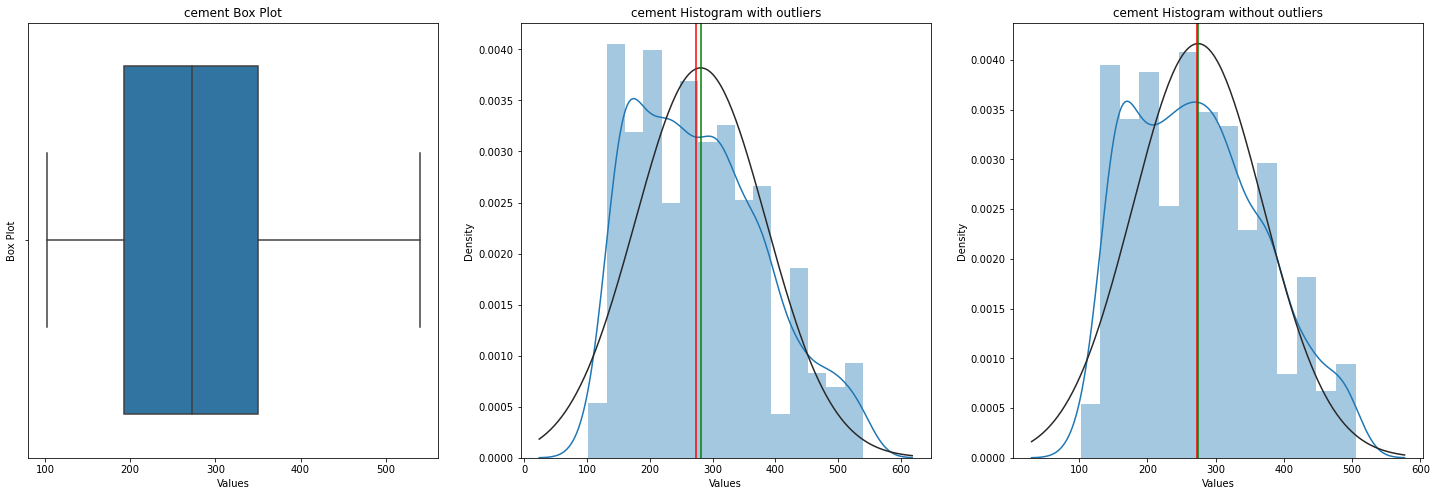

Feature slag has outliers


Total number of outliers in slag are 16


Outliers percentage in slag is 2.0


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
21,228.0,342.1,0.0,185.7,0.0,955.8,674.3,7,21.92
46,193.5,290.2,0.0,185.7,0.0,998.2,704.3,7,17.20
115,192.0,288.0,0.0,192.0,0.0,929.8,716.1,3,12.79
285,203.5,305.3,0.0,203.5,0.0,963.4,630.0,90,51.86
343,193.5,290.2,0.0,185.7,0.0,998.2,704.3,28,32.63
347,192.0,288.0,0.0,192.0,0.0,929.8,716.1,90,50.73
405,203.5,305.3,0.0,203.5,0.0,963.4,630.0,28,41.68
516,203.5,305.3,0.0,203.5,0.0,963.4,630.0,7,19.54
564,228.0,342.1,0.0,185.7,0.0,955.8,674.3,28,39.70
603,210.7,316.1,0.0,185.7,0.0,977.0,689.3,7,21.82


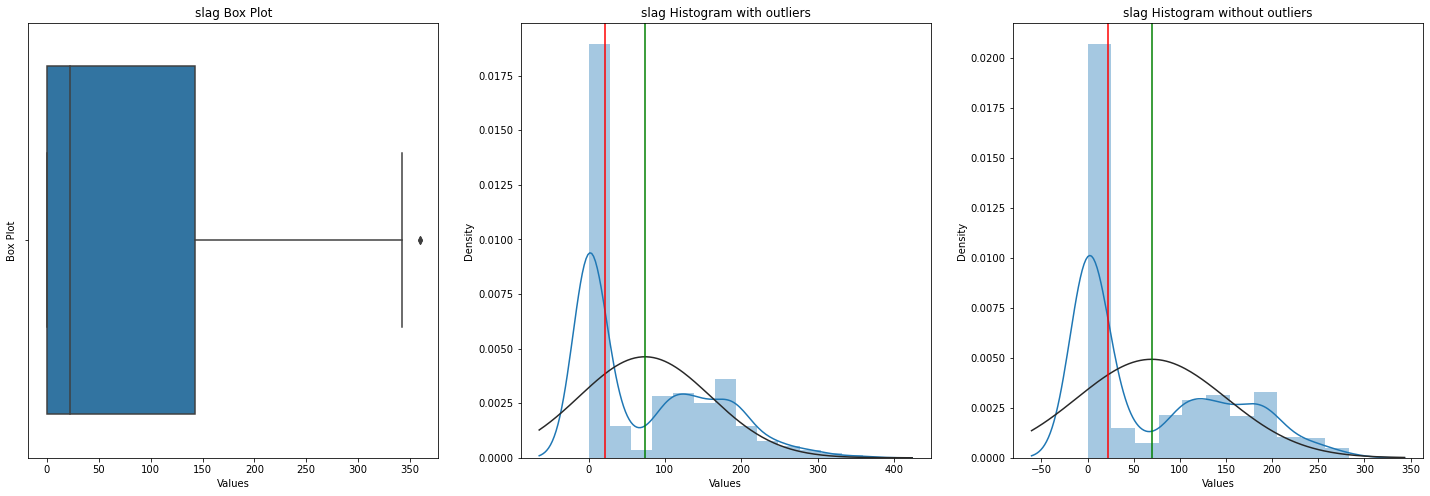

Feature ash doesnot have any outliers




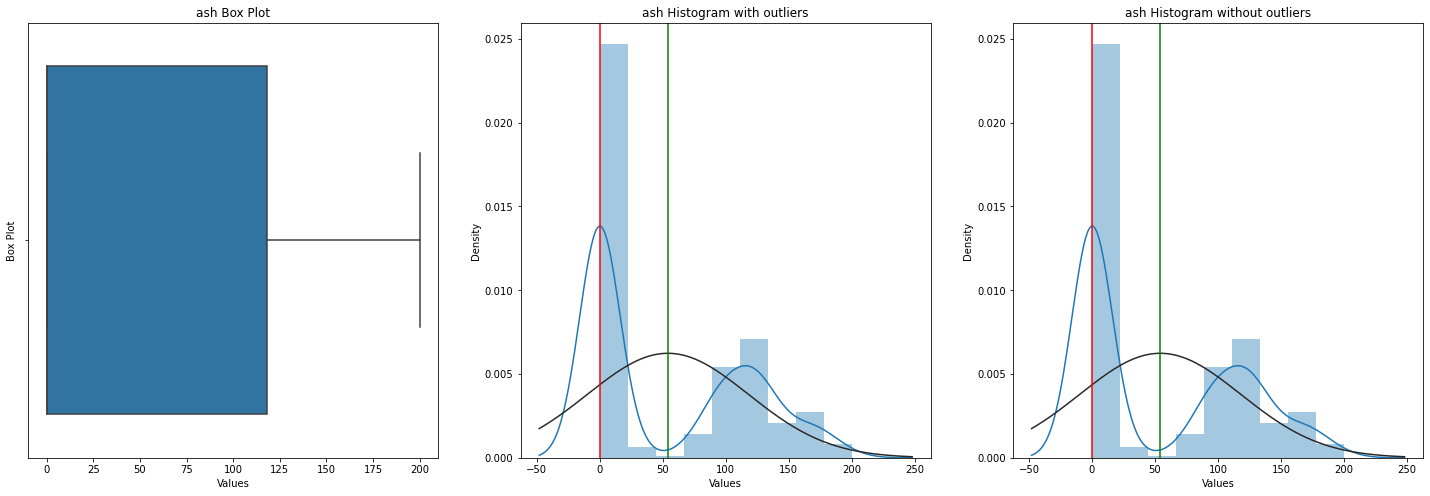

Feature water has outliers


Total number of outliers in water are 70


Outliers percentage in water is 7.000000000000001


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
3,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,45.85
13,237.5,237.5,0.0,228.0,0.0,932.0,594.0,7,26.26
16,237.5,237.5,0.0,228.0,0.0,932.0,594.0,28,30.08
26,304.0,76.0,0.0,228.0,0.0,932.0,670.0,90,49.19
31,475.0,0.0,0.0,228.0,0.0,932.0,594.0,28,39.29
...,...,...,...,...,...,...,...,...,...
952,190.0,190.0,0.0,228.0,0.0,932.0,670.0,90,42.33
994,154.0,144.0,112.0,220.0,10.0,923.0,658.0,28,16.50
995,380.0,0.0,0.0,228.0,0.0,932.0,670.0,365,52.52
1006,158.0,0.0,195.0,220.0,11.0,898.0,713.0,28,8.54


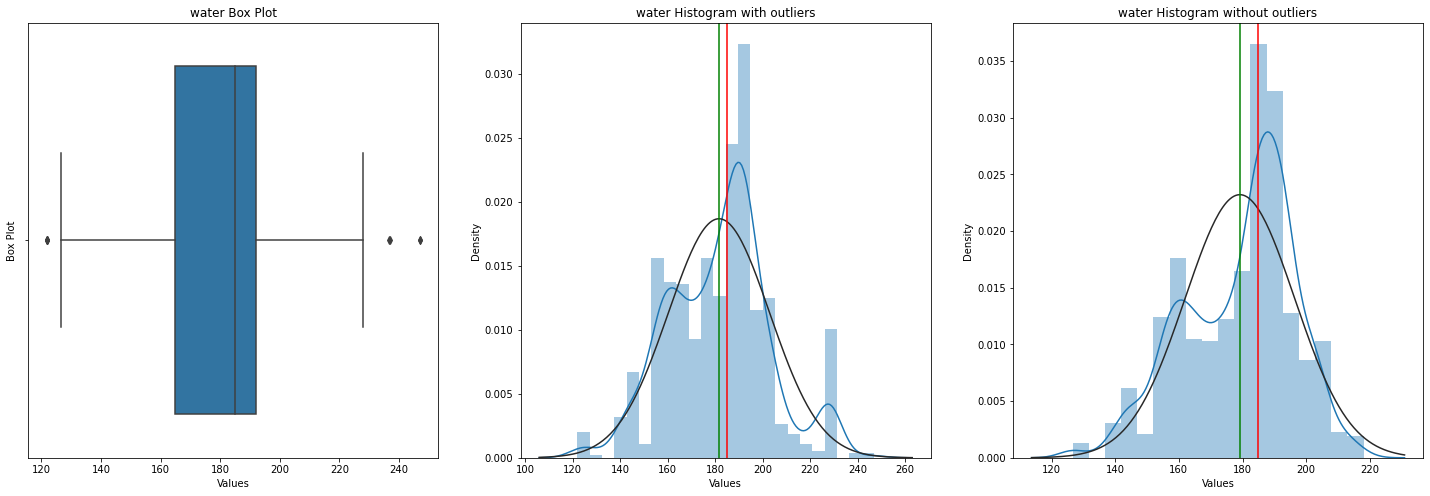

Feature superplastic has outliers


Total number of outliers in superplastic are 23


Outliers percentage in superplastic is 2.0


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
44,272.9,0.0,0.0,141.8,28.2,852.1,893.7,91,59.20
54,309.9,142.8,111.2,167.8,22.1,913.9,651.2,28,38.22
110,397.0,17.2,158.0,167.0,20.8,967.0,633.0,28,55.65
129,375.0,93.8,0.0,126.6,23.4,852.1,992.6,91,62.50
156,272.9,0.0,0.0,141.8,28.2,852.1,893.7,28,56.40
177,389.9,189.0,0.0,145.9,22.0,944.7,755.8,3,40.60
232,469.0,117.2,0.0,137.8,32.2,852.1,840.5,56,69.30
257,389.9,189.0,0.0,145.9,22.0,944.7,755.8,56,79.40
273,389.9,189.0,0.0,145.9,22.0,944.7,755.8,28,74.50
292,469.0,117.2,0.0,137.8,32.2,852.1,840.5,91,70.70


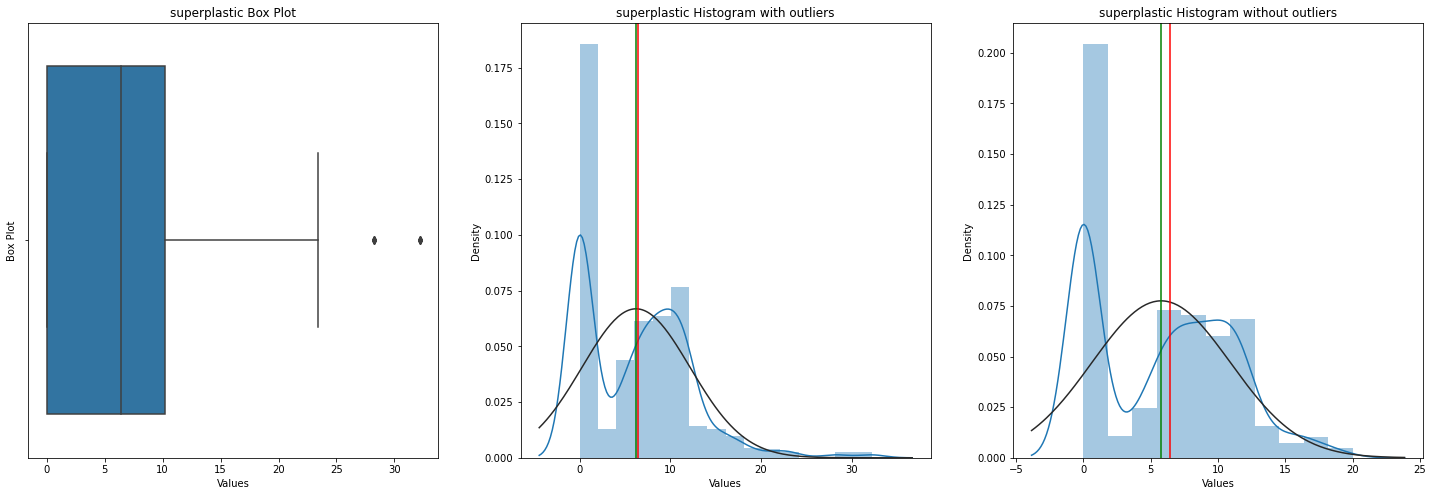

Feature coarseagg has outliers


Total number of outliers in coarseagg are 7


Outliers percentage in coarseagg is 1.0


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
50,200.0,200.0,0.0,190.0,0.0,1145.0,660.0,28,49.25
63,379.5,151.2,0.0,153.9,15.9,1134.3,605.0,56,54.90
192,315.0,137.0,0.0,145.0,5.9,1130.0,745.0,28,81.75
212,379.5,151.2,0.0,153.9,15.9,1134.3,605.0,28,52.20
553,379.5,151.2,0.0,153.9,15.9,1134.3,605.0,7,47.10
902,379.5,151.2,0.0,153.9,15.9,1134.3,605.0,91,56.50
908,379.5,151.2,0.0,153.9,15.9,1134.3,605.0,3,28.60


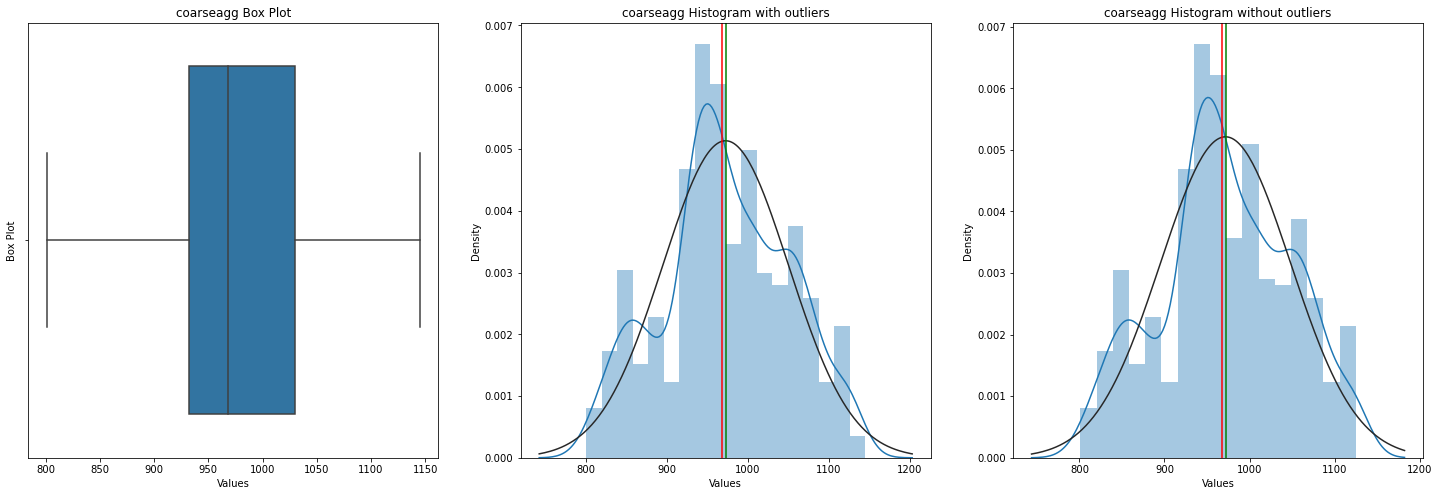

Feature fineagg has outliers


Total number of outliers in fineagg are 22


Outliers percentage in fineagg is 2.0


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
5,255.0,0.0,0.0,192.0,0.0,889.8,945.0,90,21.86
72,388.6,97.1,0.0,157.9,12.1,852.1,925.7,3,28.10
129,375.0,93.8,0.0,126.6,6.4,852.1,992.6,91,62.50
183,102.0,153.0,0.0,192.0,0.0,887.0,942.0,7,7.68
365,153.0,102.0,0.0,192.0,0.0,888.0,943.1,90,26.32
373,388.6,97.1,0.0,157.9,12.1,852.1,925.7,28,50.70
390,102.0,153.0,0.0,192.0,0.0,887.0,942.0,90,25.46
407,102.0,153.0,0.0,192.0,0.0,887.0,942.0,3,4.57
417,102.0,153.0,0.0,192.0,0.0,887.0,942.0,28,17.28
418,388.6,97.1,0.0,157.9,12.1,852.1,925.7,91,57.60


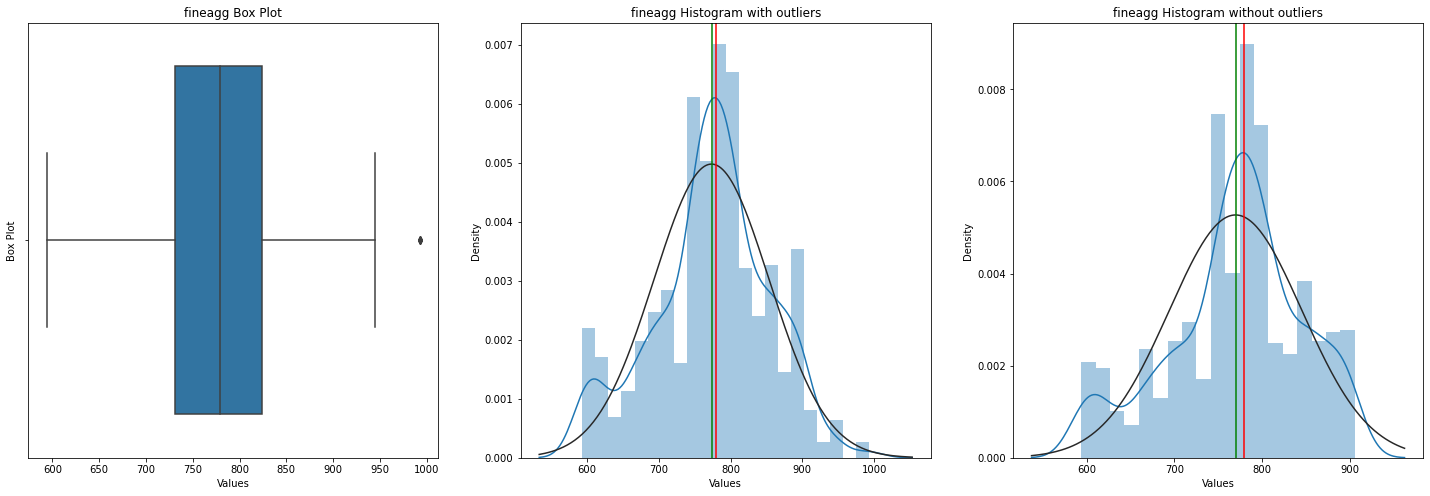

Feature age has outliers


Total number of outliers in age are 62


Outliers percentage in age is 6.0


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
51,331.0,0.0,0.0,192.0,0.0,978.0,825.0,180,39.00
64,332.5,142.5,0.0,185.0,0.0,932.0,594.0,365,41.05
93,427.5,47.5,0.0,185.0,0.0,932.0,594.0,180,41.84
99,237.5,237.5,0.0,185.0,0.0,932.0,594.0,180,36.25
103,380.0,0.0,0.0,185.0,0.0,932.0,670.0,180,53.10
...,...,...,...,...,...,...,...,...,...
971,349.0,0.0,0.0,192.0,0.0,1047.0,806.0,180,41.05
985,350.0,0.0,0.0,203.0,0.0,974.0,775.0,180,32.72
995,380.0,0.0,0.0,185.0,0.0,932.0,670.0,365,52.52
1017,139.6,209.4,0.0,192.0,0.0,1047.0,806.9,180,44.21


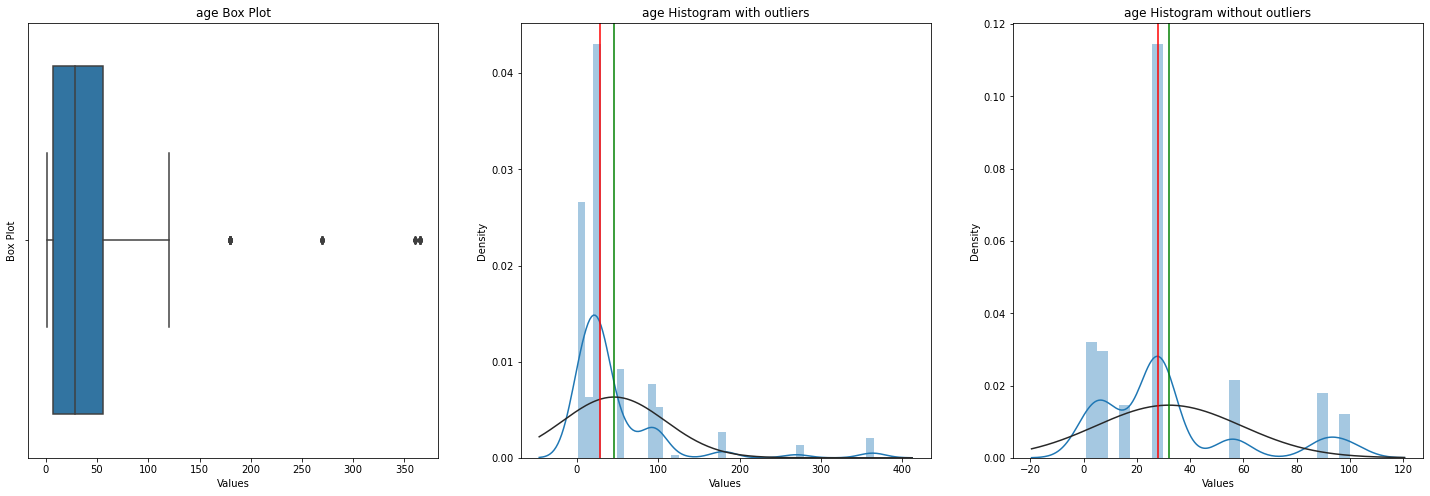

Feature strength has outliers


Total number of outliers in strength are 40


Outliers percentage in strength is 4.0


,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
96,362.6,189.0,0.0,164.9,11.6,944.7,755.8,28,71.30
128,323.7,282.8,0.0,183.8,10.3,942.7,659.9,28,74.70
190,362.6,189.0,0.0,164.9,11.6,944.7,755.8,56,77.30
192,315.0,137.0,0.0,145.0,5.9,968.0,745.0,28,81.75
232,469.0,117.2,0.0,137.8,6.4,852.1,840.5,56,69.30
239,439.0,177.0,0.0,186.0,11.1,884.9,707.9,56,71.70
245,362.6,189.0,0.0,164.9,11.6,944.7,755.8,91,79.30
257,389.9,189.0,0.0,145.9,6.4,944.7,755.8,56,79.40
273,389.9,189.0,0.0,145.9,6.4,944.7,755.8,28,74.50
292,469.0,117.2,0.0,137.8,6.4,852.1,840.5,91,70.70


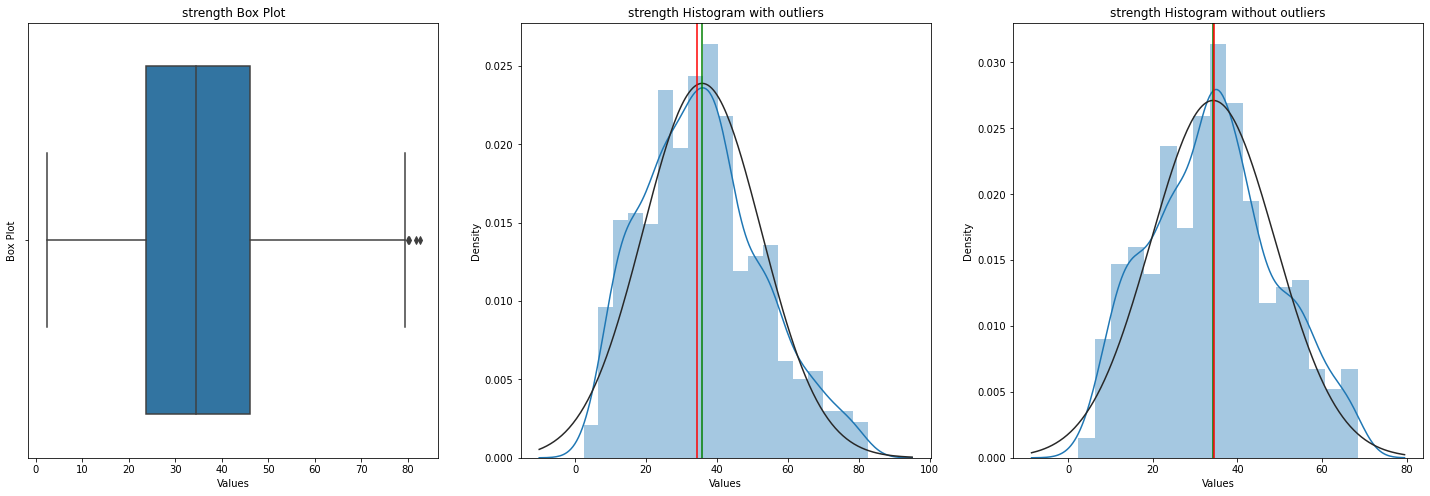

In [95]:
for col in df.columns:
    odt_plots(df, col)

**Multivariate Analysis using Regression**

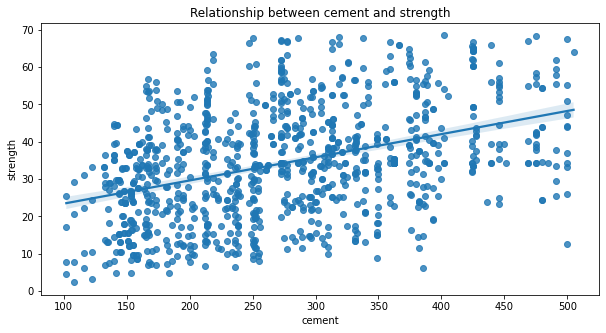

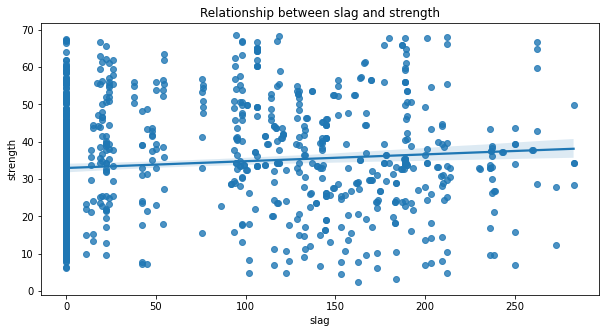

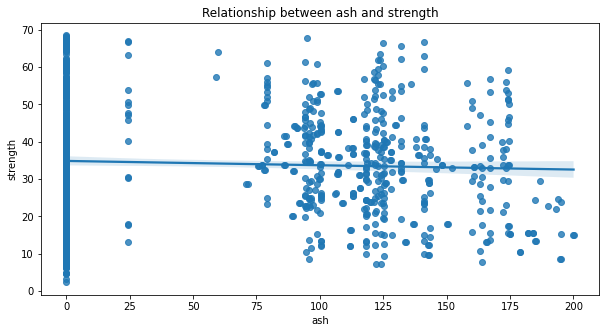

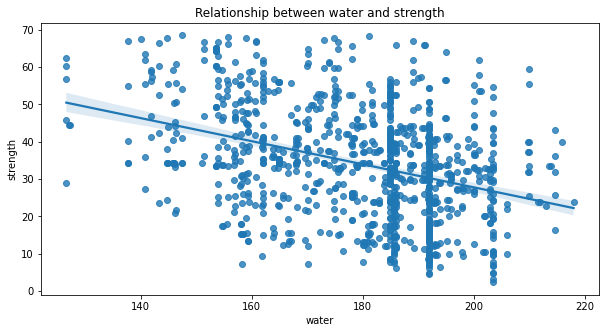

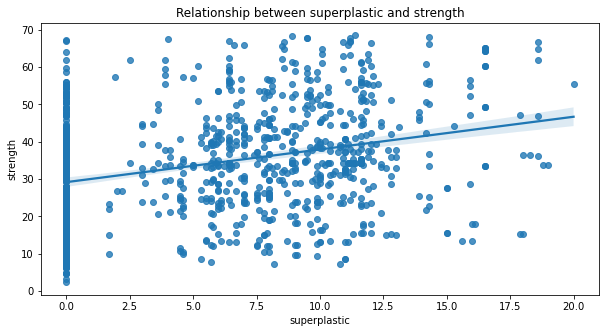

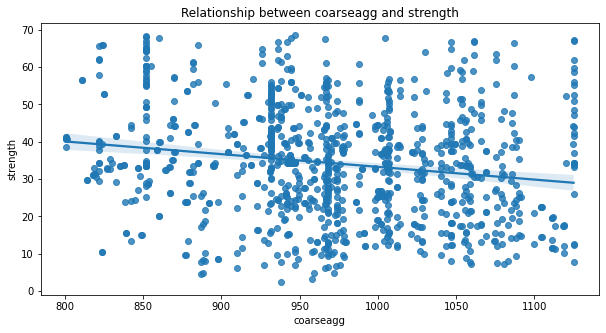

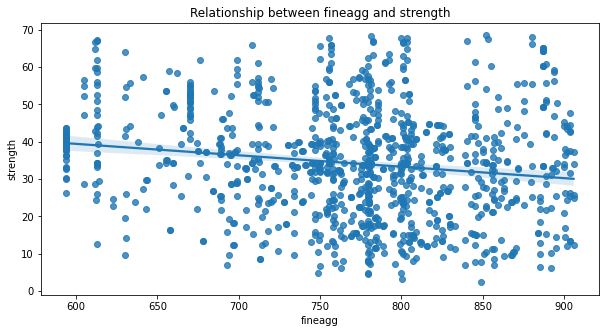

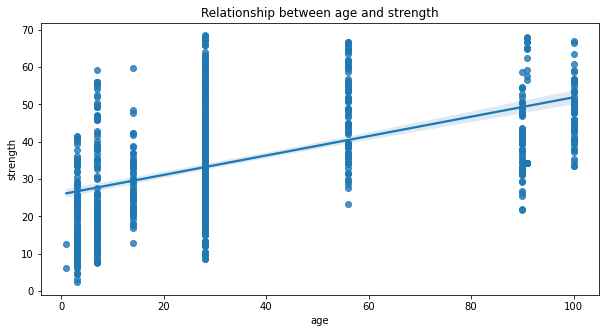

In [96]:
for col in df.columns:
    if col != "strength":
        fig,ax1 = plt.subplots(figsize = (10,5))
        sns.regplot(x = df[col], y = df["strength"], ax = ax1).set_title(f'Relationship between {col} and strength')
        

**Analysis from Regression Plot**
1. Cement and Strength are Highly +vely correlated.
2. Slag and Strength are slightly +vely correlated.
3. Ash and strength are slightly -vely correlated.
4. Water and Strength are highly -vely correlated.
5. Superplastic and Strength are highly +vely correlated.
6. Coarseagg and Strength are sightly -vely correlated.
7. Fineagg and Strength are highly -vely correlated.
8. Age and Strength are highly +vely correlated.

**Multi Colinearity Test
1. Correlation matrix or Heat Map (Stage 1)

<AxesSubplot:>

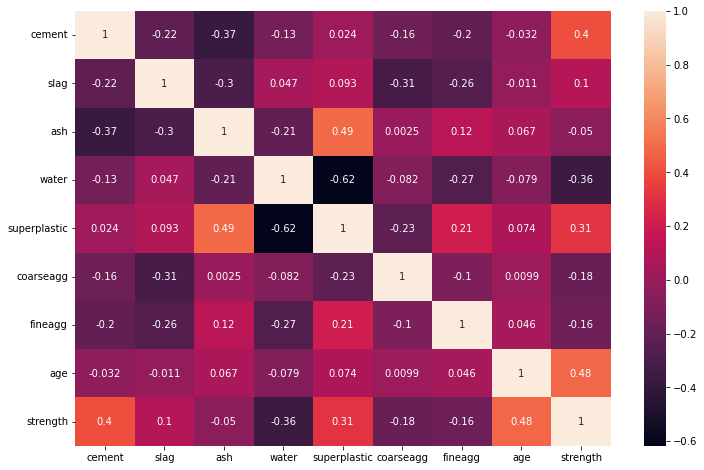

In [97]:
corr = df.corr()
df.ax = plt.subplots(figsize = (12,8))
sns.heatmap(corr, annot = True)

**Analysis from Stage1 test**
1. Slag have high correlation with ash
2. Ash has high correlation with cement

**Multi collinearity test** (Homework)
1. VIF (Variance Inflation Factor)

**Corelation with target feature**

In [98]:
def corelation_with_target(data, t_col):
    independent_variable = data.drop(t_col, axis = 1).columns
    corr_result = []
    for col in independent_variable:
        corr_result.append(data[t_col].corr(data[col]))
    result = pd.DataFrame([independent_variable, corr_result], index = ['Independent Variables', 'Corelation']).T
    return result.sort_values('Corelation', ascending = False)

In [99]:
corelation_with_target(df, 'strength')

,Independent Variables,Corelation
7,age,0.483496
0,cement,0.40391
4,superplastic,0.306322
1,slag,0.100339
2,ash,-0.050195
6,fineagg,-0.157437
5,coarseagg,-0.177341
3,water,-0.361032


**Analysis of corelation between Independent and Dependent Variable**
1. Age and Cement have 49% and 40% corelation with Strength
2. Superplastic and Water have 30% and 36% corelation with Strength

**Applying PCA to treat Multicollinearity**

In [100]:
def custom_PCA(X):
    n_comp=len(X.columns)
    
    #Appyling StandardScaler for Feature Scaling
    sc = StandardScaler()
    X = sc.fit_transform(X) #import this lines afterwards
    
    for i in range(1,n_comp):
        pca=PCA(n_components=i)
        p_comp=pca.fit_transform(X)
        evr=np.cumsum(pca.explained_variance_ratio_) #evr is nothing but cumulative sume of previous iterationo
        if evr[i-1]>0.9:
            pcs=i
            break
    print('Explained Variance ratio after PCA is: ', evr)
    #Crearing a dataframe of principal components
    col=[]
    for j in range(1,pcs+1):
        col.append('PC_'+str(j))
    pca_df=pd.DataFrame(p_comp,columns=col)
    return pca_df

In [101]:
pca_df = custom_PCA(df.drop("strength", axis = 1))

Explained Variance ratio after PCA is:  [0.26187014 0.44281489 0.60374962 0.72772851 0.84760518 0.95381331]


In [102]:
df.head()

,cement,slag,ash,water,superplastic,coarseagg,fineagg,age,strength
0,141.3,212.0,0.0,203.5,0.0,971.8,748.5,28,29.89
1,168.9,42.2,124.3,158.3,10.8,1080.8,796.2,14,23.51
2,250.0,0.0,95.7,187.4,5.5,956.9,861.2,28,29.22
3,266.0,114.0,0.0,185.0,0.0,932.0,670.0,28,45.85
4,154.8,183.4,0.0,193.3,9.1,1047.4,696.7,28,18.29


## Joining PCA features with target features

In [103]:
pca_df = pca_df.join(df["strength"], how = "left") #Left join

In [104]:
pca_df.head()

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,strength
0,-1.978224,0.346866,-2.107863,0.023370,0.221852,-0.729356,29.89
1,1.861988,-1.156164,-0.445617,-0.241155,-1.305533,-0.866639,23.51
2,0.627599,-0.869541,-0.153988,-0.836518,0.918121,0.421226,29.22
3,-1.760743,0.602714,-0.266157,0.241167,-0.318107,0.122704,45.85
4,-0.925245,0.333615,-1.509934,0.619216,-1.100183,-0.916288,18.29


## Model building
### Stages of Model Building
1. Custom train test split function
2. Cross Validation
3. Hyper Parameter Tuning

In [105]:
def train_and_test(data, tcol, testsize = 0.3, randomstate = 42):
    X = data.drop(tcol, axis = 1)
    y = data[tcol]
    return train_test_split(X,y,test_size = testsize, random_state = randomstate)

In [106]:
def model_builder(model_name, model, data, t_col):
    X_train, X_test, y_train, y_test = train_and_test(data, t_col)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    result = [model_name, rmse, r2]
    return result

In [109]:
model_builder(model_name = "LinearRegression", model = LinearRegression(), data = pca_df, t_col = 'strength')

['LinearRegression', 10.040785018544426, 0.51833857331758]

In [123]:
def multiple_models(data, t_col):
    column_names = ["Model", "RMSE", "r2_value"]
    result = pd.DataFrame(columns = column_names)
    result.loc[len(result)] = model_builder("Linear Regression", LinearRegression(), data, t_col)
    result.loc[len(result)] = model_builder("Lasso Regression", Lasso(), data, t_col)
    result.loc[len(result)] = model_builder("Ridge Regression", Ridge(), data, t_col)
    result.loc[len(result)] = model_builder("Decision Tree", DecisionTreeRegressor(), data, t_col)
    result.loc[len(result)] = model_builder("Support Vector Machine", SVR(), data, t_col)
    result.loc[len(result)] = model_builder("Random Forrest", RandomForestRegressor(), data, t_col)
    result.loc[len(result)] = model_builder("k Nearest Neighbors", KNeighborsRegressor(), data, t_col)
    result.loc[len(result)] = model_builder("ADA Boost", AdaBoostRegressor(), data, t_col)
    result.loc[len(result)] = model_builder("Gradient Boost", GradientBoostingRegressor(), data, t_col)
    result.loc[len(result)] = model_builder("XG Boost", XGBRegressor(), data, t_col)
    return result.sort_values("r2_value", ascending = False)

In [124]:
multiple_models(pca_df, 'strength')

,Model,RMSE,r2_value
5,Random Forrest,6.902960,0.772345
9,XG Boost,7.037480,0.763386
8,Gradient Boost,7.723999,0.714970
6,k Nearest Neighbors,8.376555,0.664774
7,ADA Boost,8.747132,0.634457
4,Support Vector Machine,9.156255,0.599463
2,Ridge Regression,10.039699,0.518443
0,Linear Regression,10.040785,0.518339
1,Lasso Regression,10.141907,0.508588
3,Decision Tree,10.316461,0.491527


## Cross Validation

In [149]:
def k_fold_cv(X, y, fold = 10):
    score_lr = cross_val_score(LinearRegression(),X, y, cv = fold)
    score_ls= cross_val_score(Lasso(),X, y, cv = fold)
    score_rd=cross_val_score(Ridge(), X,y, cv = fold)
    score_dt=cross_val_score(DecisionTreeRegressor(),X, y, cv = fold)
    score_sv=cross_val_score(SVR(),X, y, cv = fold)
    score_k= cross_val_score(KNeighborsRegressor(),X, y, cv = fold)
    score_rf= cross_val_score(RandomForestRegressor(),X, y, cv = fold)
    score_ad= cross_val_score(AdaBoostRegressor(),X, y, cv = fold)
    score_gb= cross_val_score(GradientBoostingRegressor(),X, y, cv = fold)
    score_xg= cross_val_score(XGBRegressor(),X, y, cv = fold)
    
    model_name = ['LinearRegression','Lasso Regression', 'Ridge Regression', 'Decision Tree', 'SVM', 'KNN', 'Random Forrest', 'ADA Boost','Gradient Boost','XG Boost']
    scores = [score_lr, score_ls, score_rd,score_dt, score_sv, score_k,score_rf,score_ad,score_gb,score_xg]
    
    result = []
    for i in range (len(model_name)):
        score_mean = np.mean(scores[i])
        score_std = np.std(scores[i])
        m_name = model_name[i]
        temp = [m_name, score_mean, score_std]
        result.append(temp)
    k_fold_df = pd.DataFrame(result, columns = ["model_name", "CV Accuracy", "CV Std. Deviation"])
    return k_fold_df.sort_values("CV Accuracy", ascending = False)

In [150]:
k_fold_cv(pca_df.drop('strength', axis = 1), pca_df['strength'])

,model_name,CV Accuracy,CV Std. Deviation
6,Random Forrest,0.771733,0.040064
9,XG Boost,0.761088,0.038119
8,Gradient Boost,0.710231,0.044088
5,KNN,0.692140,0.057124
3,Decision Tree,0.628898,0.064102
4,SVM,0.602557,0.040321
7,ADA Boost,0.600620,0.077747
2,Ridge Regression,0.543134,0.084732
0,LinearRegression,0.543121,0.084829
1,Lasso Regression,0.523444,0.069430
